In [1]:
!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("aklimarimi/8-facial-expressions-for-yolo")

print("Path to dataset files:", path)

100%|██████████| 3.77G/3.77G [00:52<00:00, 76.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aklimarimi/8-facial-expressions-for-yolo/versions/4


In [7]:
# Constants
IMG_SIZE = 48
# DATA_DIR = '/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need/'
DATA_DIR = os.path.join(path, '9 Facial Expressions you need') # Use the path returned by kagglehub.dataset_download

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']


In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [12]:
# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Reduce dataset size
n_train = 5000
n_test = 3000

train_images = images[:n_train]
train_labels = labels[:n_train]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [13]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.5 MB/s eta 0:00:00


In [14]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers


SAVE_PATH = ""  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Quantum pre-processing of train images:

Quantum pre-processing of test images:


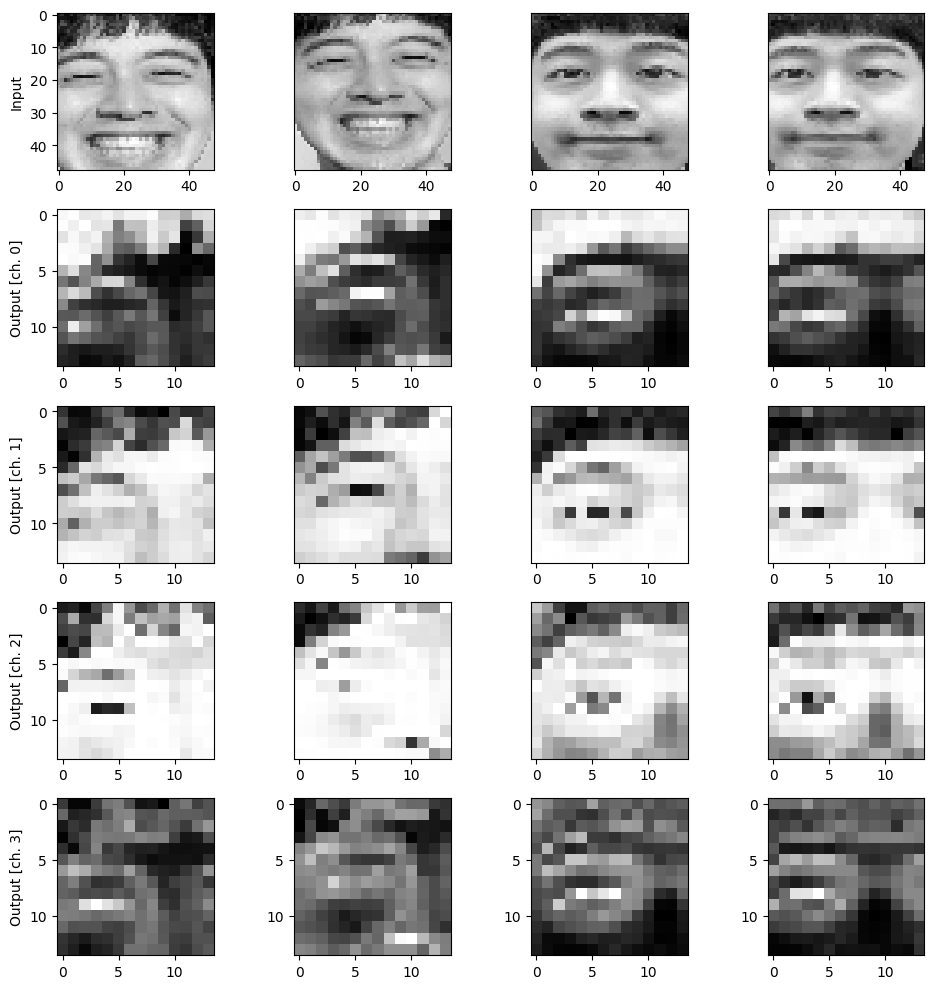

In [15]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [22]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=800,
    verbose=2,
)

Epoch 1/800
425/425 - 7s - 17ms/step - accuracy: 0.2371 - loss: 2.0734 - val_accuracy: 0.3071 - val_loss: 1.8595
Epoch 2/800
425/425 - 3s - 6ms/step - accuracy: 0.3035 - loss: 1.8802 - val_accuracy: 0.3594 - val_loss: 1.7587
Epoch 3/800
425/425 - 2s - 5ms/step - accuracy: 0.3429 - loss: 1.7771 - val_accuracy: 0.3876 - val_loss: 1.6833
Epoch 4/800
425/425 - 2s - 5ms/step - accuracy: 0.3724 - loss: 1.6979 - val_accuracy: 0.4094 - val_loss: 1.6217
Epoch 5/800
425/425 - 1s - 4ms/step - accuracy: 0.4006 - loss: 1.6327 - val_accuracy: 0.4382 - val_loss: 1.5692
Epoch 6/800
425/425 - 2s - 5ms/step - accuracy: 0.4282 - loss: 1.5771 - val_accuracy: 0.4559 - val_loss: 1.5233
Epoch 7/800
425/425 - 3s - 6ms/step - accuracy: 0.4465 - loss: 1.5285 - val_accuracy: 0.4688 - val_loss: 1.4826
Epoch 8/800
425/425 - 3s - 7ms/step - accuracy: 0.4688 - loss: 1.4854 - val_accuracy: 0.4918 - val_loss: 1.4460
Epoch 9/800
425/425 - 4s - 10ms/step - accuracy: 0.4841 - loss: 1.4466 - val_accuracy: 0.5053 - val_los

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

       Happy       0.95      1.00      0.98       297
         Sad       1.00      1.00      1.00        68
       Angry       1.00      1.00      1.00        98
   Surprised       1.00      0.99      0.99       144
     Neutral       1.00      0.95      0.97       407
   Disgusted       0.95      0.99      0.97       136
        Fear       0.99      0.99      0.99       298
      Sleepy       1.00      1.00      1.00        33
    Contempt       0.98      0.99      0.99       219

    accuracy                           0.98      1700
   macro avg       0.99      0.99      0.99      1700
weighted avg       0.98      0.98      0.98      1700



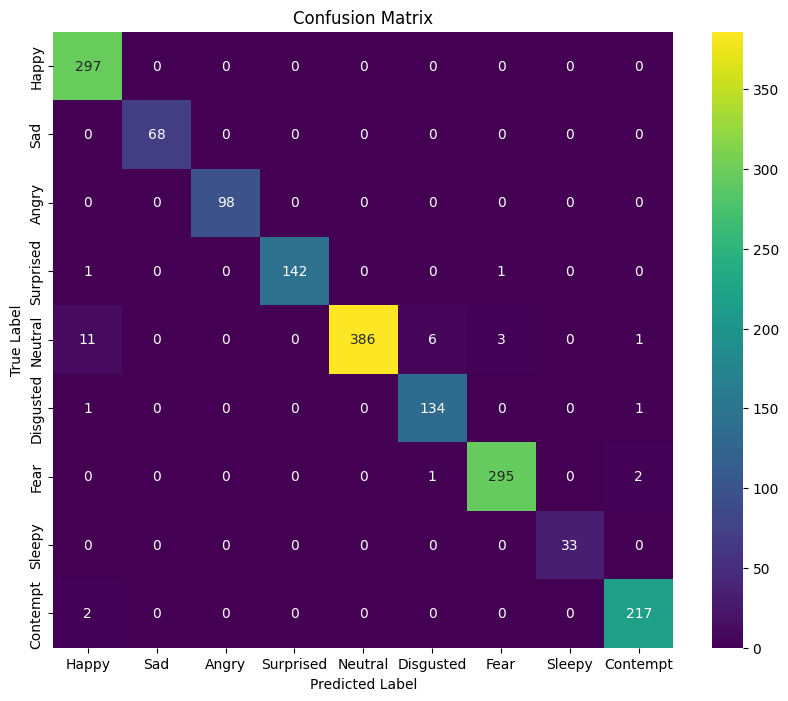

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the EMOTIONS list based on the emotion_labels dictionary
EMOTIONS = list(idx_to_emotion.values())

# Step 1: Generate predictions
y_pred = q_model.predict(q_test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels     # Ground truth labels

# Step 2: Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Visualize confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

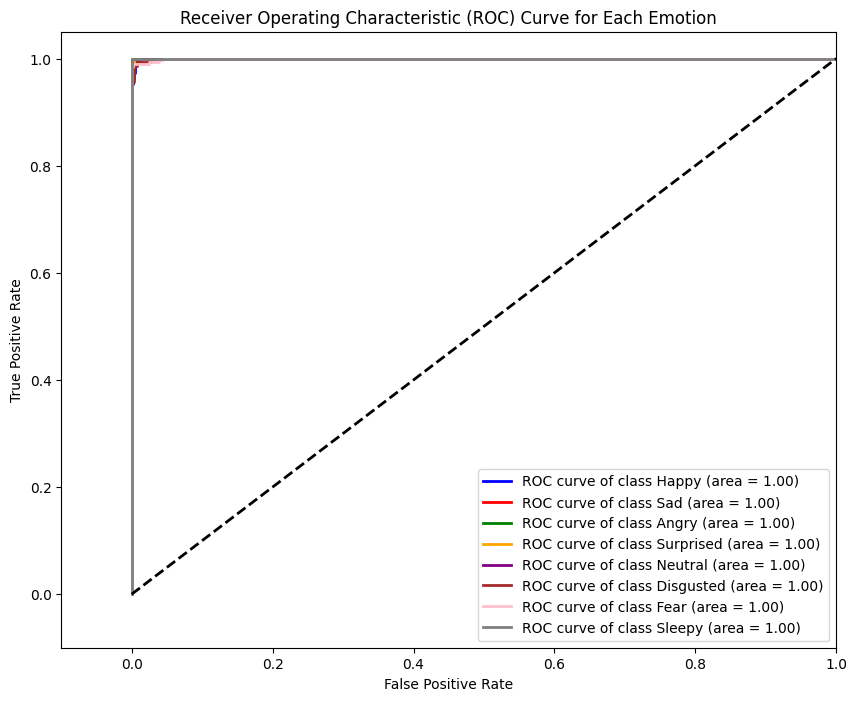

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC analysis
y_true_binarized = label_binarize(y_true, classes=range(len(EMOTIONS)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(EMOTIONS)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color in zip(range(len(EMOTIONS)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Emotion')
plt.legend(loc="lower right")
plt.show()
